In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint

import numpy as np
from sklearn.preprocessing import scale
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import matplotlib.animation as ani

import mlgrad.models as models
import mlgrad.regr as regr
import mlgrad.cls as cls
import mlgrad.pca as pca
import mlgrad.plots as plots
import mlgrad.funcs as funcs
import mlgrad.funcs2 as funcs2
import mlgrad.loss as loss
import mlgrad.gd as gd
import mlgrad.smooth as smooth
import mlgrad.array_transform as at
from mlgrad.af import averaging_function
import mlgrad.avragg as avragg

import rampy
import pybaselines
import random

from irsa import io
from irsa.preprocess import despike, utils
import irsa.widgets as widgets

import scipy.special as special

import copy

import ipywidgets
from IPython.display import display

# %matplotlib widget

In [2]:
path = f"/home/intellimath/repos/spectras/bacteria1024"
options = {}
dd = {}
widgets.load_spectras(path, dd, options)

Box(children=(VBox(children=(Label(value='дата:', style=LabelStyle(font_size='8pt', font_weight='bold')), Sele…

Button(description='Select', style=ButtonStyle())

Output()

{}

In [3]:
print(list(dd.keys()))

['SA_100_S_less50more30_6_21_1_20241024_H2O(HPLC)', 'SA_100_S_less50more30_6_22_1_20241024_H2O(HPLC)']


In [4]:
d_keys = list(sorted(dd.keys()))
sel_i = 0
sel = ipywidgets.Select(options=d_keys,  description="Experiment:", rows=len(dd)+1)
sel.layout.width="50%"

# def sel_on_value_change(change):
#     i_slider.value = 0
#     i_slider.max = len(dd[sel.value].y)-1

# def i_on_value_change(change):
#     plot_spectra_series(sel.value, i_slider.value, f_slider.value)

# def f_on_value_change(change):
#     plot_spectra_series(sel.value, i_slider.value, f_slider.value)

# def tau_on_value_change(change):
#     plot_spectra_series(sel.value, i_slider.value, f_slider.value, tau_slider.value)

# sel.on_trait_change(sel_on_value_change, name="value")
# i_slider.on_trait_change(i_on_value_change, name="value")
# f_slider.on_trait_change(f_on_value_change, name="value")
# tau_slider.on_trait_change(tau_on_value_change, name="value")

# ipywidgets.VBox([sel, i_slider, out])

In [5]:
for i, key in enumerate(dd):
    entry1 = dd[key]
    # entry1.to_modified_zscore()
    # entry1.allign_bottom()
    entry1.crop(70)


In [6]:
# for i, key in enumerate(dd):
#     entry1 = dd[key]
#     xs, ys = entry1.x, entry1.y
#     plt.figure(figsize=(12,4))
#     plt.title(key)
#     for x, y in zip(xs,ys):
#         mu = np.median(y, axis=0)
#         std = np.median(abs(y-mu), axis=0)
#         plt.plot(x, 100*std/mu)
#         plt.minorticks_on()
#         plt.grid(1)
#     plt.hlines(5,min(x),max(x))
#     plt.show()

In [7]:
@ipywidgets.interact(key=sel)
def plot_spectra_for_key(key):
    entry = dd[key]
    entry.plot_spectras()

interactive(children=(Select(description='Experiment:', layout=Layout(width='50%'), options=('SA_100_S_less50m…

In [8]:
# for i, key in enumerate(dd):
#     entry1 = dd[key]

    # entry1.remove_overflow_spectras(y_max=2000.0, y_max_count=30)
    # entry1.remove_outlier_spectras(delta=0.10, tau=3.5)
    # entry1.remove_by_zscore_spectras(tau=3.5, max_count=50)
    # print(len(entry1.y))

In [9]:
d2 = {}
for i, key in enumerate(dd):
    entry2 = dd[key]
    d2[key] = entry2.robust_averaging(tau=3.0)


In [10]:
for key in d2:
    entry = d2[key]
    entry.scale(scale=100.0, tau=3.0)
    entry.allign_bottom()
    # entry.apply_func(y_func=np.log, x_func=np.log, b=1)
    

In [11]:
# for key in d2:
#     entry = d2[key]
#     entry.smooth(tau=10.0, func2=funcs.RectExp(w=10.0, p=1.0).evaluate_array)


In [12]:
@ipywidgets.interact(key=sel)
def plot_spectra_for_key(key, tau=1.0, ):
    entry = d2[key]
    entry.plot_spectras(tau=tau, ss=20)

interactive(children=(Select(description='Experiment:', layout=Layout(width='50%'), options=('SA_100_S_less50m…

In [15]:
# def func1(E):
#     # return (1 - E / np.sqrt(1 + E*E)) / 2
#     return special.expit(-10*(E-4))

# def func2(E,D):    
#     return (1 + E / np.sqrt(1 + E*E))
#     E = abs(E)
#     return E / E.max()



@ipywidgets.interact(key=sel)
def plot_spectra_for_key(key):
    entry = d2[key]
    entry.select_baselines(tau2=1.0, tau_z=0.0, bs_scale=2.5, solver="fast", d=2, func2_mode="d",
                           ww=100, tau_smooth=1,
                           func=funcs.Hinge2(1.0e-7),
                           # func2=funcs.Absolute(),
                          )

interactive(children=(Select(description='Experiment:', layout=Layout(width='50%'), options=('SA_100_S_less50m…

In [14]:
for i, key in enumerate(d2):
    entry3 = d2[key]
    # entry3.smooth(method="irsa", tau=1.)
    # entry3.allign_bottom()
    # entry3.normalize_area_under_curve()
    # entry3.remove_by_zscore_spectras(tau=3.5, max_count=40)
    entry3.subtract_baseline("aspls", lam=1.0e5)
    # entry3.replace_small_values(0.01)
    # entry3.normalize_area_under_curve()
    # print(entry3.x.shape, entry3.y.shape)
    # entry3.y = entry3.remove_outlier_spectras(tau=3.5)
    # Is = [i for i,ys in enumerate(entry3.y) if np.any(np.isnan(ys))]
    # print(Is)            


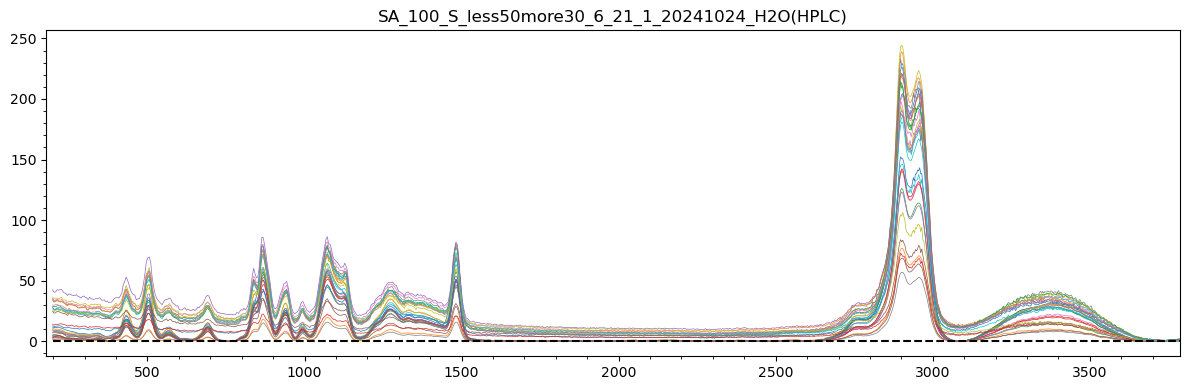

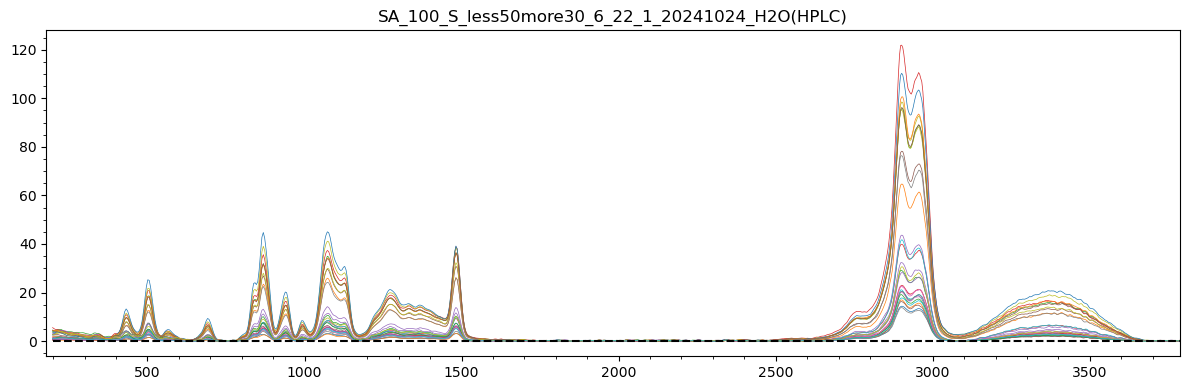

In [26]:
for i, key in enumerate(d2):
    entry = d2[key]
    Xs, Ys = entry.x, entry.y

    plt.figure(figsize=(12,4))
    plt.title(key)
    for xs, ys in zip(Xs, Ys):
        plt.plot(xs, ys, linewidth=0.5)
    plt.hlines(0, min(xs), max(xs), colors='k', linestyles='--')
    plt.xlim(min(xs)-20, max(xs))
        
    plt.minorticks_on()
    plt.tight_layout()
    # plt.legend()
    plt.show()
    
    # plt.figure(figsize=(12,3))
    # Zs = utils.modified_zscore2(Ys)
    # for xs,zs in zip(Xs,Zs):
    #     plt.plot(xs,abs(zs), linewidth=0.5, marker='s', markersize=1)
    # plt.hlines(3.5, 0, max(xs), colors='k', linestyle='--')
    # plt.minorticks_on()
    # plt.tight_layout()
    # plt.show()
    

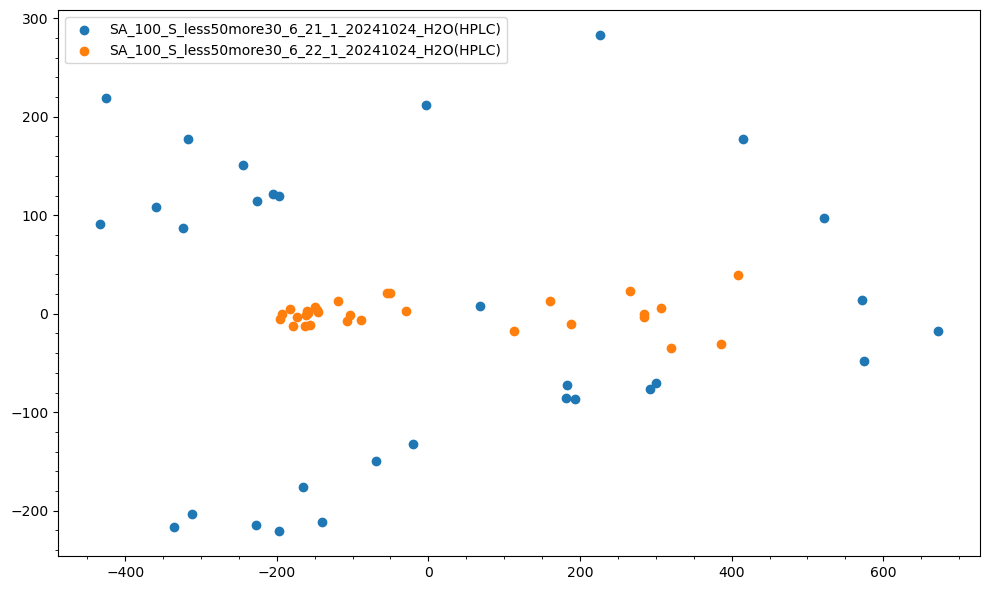

In [27]:
from sklearn.decomposition import PCA
from numpy.linalg import det, inv

plt.figure(figsize=(10,6))
for i, key in enumerate(d2):
    entry = d2[key]
    Xs, Ys = entry.x, entry.y

    pca = PCA(5)
    pca.fit(Ys)
    Us = pca.transform(Ys)

    S = Us.T @ Us
    S /= np.sqrt(det(S))
    S = inv(S)
    # print(S)


    sc = plt.scatter(Us[:,0], Us[:,1], label=key)
    c = sc.get_facecolor()

    # x_min, x_max = min(Us[:,0]), max(Us[:,0])
    # y_min, y_max = min(Us[:,1]), max(Us[:,1])

    # xr = np.linspace(x_min, x_max, 50)
    # yr = np.linspace(y_min, y_max, 50)
    # xx, yy = np.meshgrid(xr, yr)
    # xy = np.c_[xx.ravel(), yy.ravel()]
    # dd = np.sqrt([0.5*((t @ S) @ t) for t in xy])
    # dd = dd.reshape(xx.shape)
    # plt.contour(dd, levels=[4.0], colors=c)
    

plt.minorticks_on()
plt.tight_layout()
plt.legend()
plt.show()

[[ 0.023  0.022  0.022 ...  0.000  0.000  0.000]
 [ 0.067  0.064  0.066 ... -0.004 -0.003 -0.004]]
[[ 6.277e-03  5.731e-03  5.235e-03 ...  1.402e-04  1.578e-04  1.580e-04]
 [ 5.537e-05 -2.276e-04  4.800e-04 ... -3.321e-03  1.735e-03 -4.529e-04]]


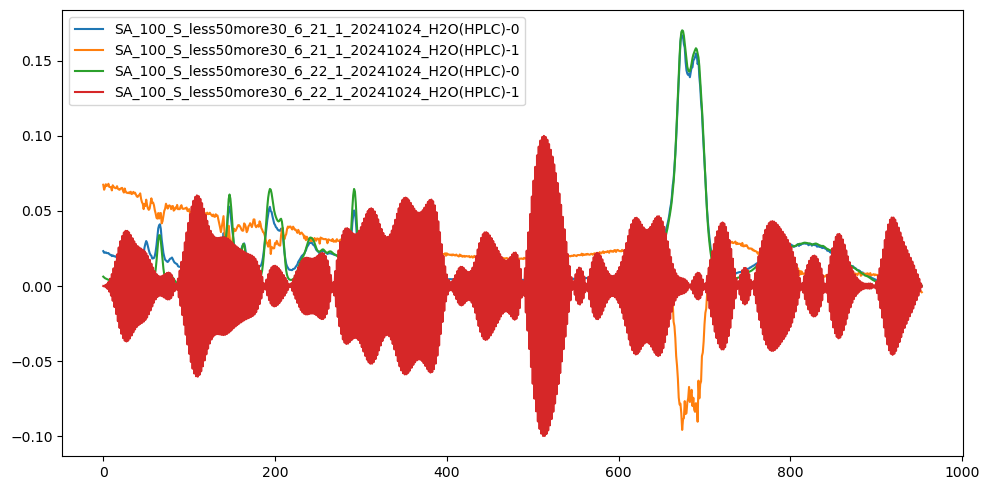

[[ 0.023  0.022  0.022 ...  0.000  0.000  0.000]
 [ 0.067  0.064  0.066 ... -0.004 -0.003 -0.004]]
[[ 0.006  0.006  0.005 ...  0.000  0.000  0.000]
 [-0.001  0.003 -0.006 ... -0.005  0.002 -0.001]]


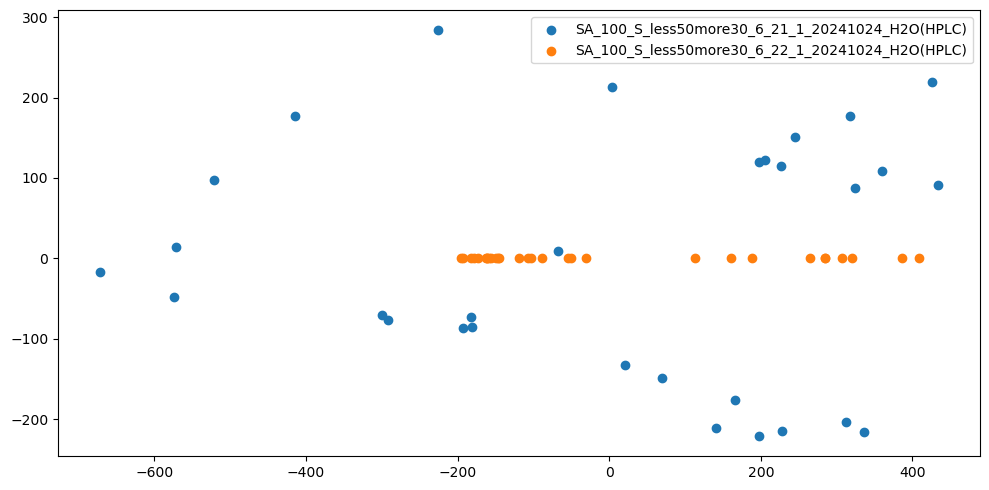

In [28]:
from mlgrad.pca import location, find_pc_all, find_pc_l1_all, find_pc_smoothed_all

plt.figure(figsize=(10,5))
for i, key in enumerate(d2):
    entry = d2[key]
    Xs, Ys = entry.x, entry.y

    C = location(Ys)
    C = smooth.whittaker_smooth(C, tau=50.0)
    # As, Ls, Us = find_pc_all(Ys - C, 2)
    As, Ls, Us = find_pc_smoothed_all(Ys - C, 2, tau=50.0)
    print(As)
    # plt.plot(Ls, marker='o', label=key)
    # plt.scatter(Us[0], Us[1], label=key)
    plt.plot(As[0], label=key+"-0")
    plt.plot(As[1], label=key+"-1")

plt.tight_layout()
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
for i, key in enumerate(d2):
    entry = d2[key]
    Xs, Ys = entry.x, entry.y

    C = location(Ys)
    C = smooth.whittaker_smooth(C, tau=50.0)
    # As, Ls, Us = find_pc_all(Ys - C, 2)
    As, Ls, Us = find_pc_smoothed_all(Ys - C, 2, tau=50.0)
    print(As)
    # plt.plot(Ls, marker='o', label=key)
    plt.scatter(Us[0], Us[1], label=key)

plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
for i, key in enumerate(d2):
    entry = d2[key]
    Xs, Ys = entry.x, entry.y

    # if "_R_" in key:
    #     if "95" in key:
    #         color='r'
    #     elif "96" in key:
    #         color='Brown'
    # elif "_S_" in key:
    #     if "92" in key:
    #         color='m'
    #     elif "93" in key:
    #         color='b'
    #     else:
    #         color='b'

    if "_R_" in key:
        color='r'
    elif "_S_" in key:
        color='b'
    else:
        color='m'
        
    # plt.plot(np.mean(Xs, axis=0), np.mean(Ys, axis=0), linewidth=1.0, color=color, label=key)
    plt.plot(np.mean(Ys, axis=0), linewidth=1.0, label=key)
    
# plt.hlines(0, 0, len(Ys[0]), colors='k')
# plt.xlim(-10,1000)
        
plt.minorticks_on()
plt.tight_layout()
plt.legend()
plt.show()

In [3]:
import sympy
from sympy import MatrixSymbol, Identity, latex

In [4]:
w = sympy.symarray("w", (8,), )
W = np.diag(w[1:-1])

In [5]:
E = np.eye(8, dtype="i")
D2 = np.diff(E, 2, axis=0)
print(D2)
print(D2.T @ D2)

[[ 1 -2  1  0  0  0  0  0]
 [ 0  1 -2  1  0  0  0  0]
 [ 0  0  1 -2  1  0  0  0]
 [ 0  0  0  1 -2  1  0  0]
 [ 0  0  0  0  1 -2  1  0]
 [ 0  0  0  0  0  1 -2  1]]
[[ 1 -2  1  0  0  0  0  0]
 [-2  5 -4  1  0  0  0  0]
 [ 1 -4  6 -4  1  0  0  0]
 [ 0  1 -4  6 -4  1  0  0]
 [ 0  0  1 -4  6 -4  1  0]
 [ 0  0  0  1 -4  6 -4  1]
 [ 0  0  0  0  1 -4  5 -2]
 [ 0  0  0  0  0  1 -2  1]]


In [6]:
DD2 = np.dot(np.dot(D2.T, W), D2)

In [7]:
from IPython.display import display, Latex

In [8]:
s = r"$$\left(\begin{array}{llllllll}"
for i in range(8):
    for j in range(8):
        s += latex(DD2[i,j])
        if j < 7:
            s += r"&"
        else:
            s += r"\\"
s += r"\end{array}\right)$$"
# print(s)
print("d a b")
print("c")
print("e")
display(Latex(s))

d a b
c
e


<IPython.core.display.Latex object>

In [8]:
D1 = np.diff(np.eye(8), 1, axis=0, )
print(D1)
print(D1.T @ D1)

[[-1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.]]
[[ 1. -1.  0.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.]
 [ 0.  0.  0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.]]


In [9]:
w = sympy.symarray("w", (7,))
W = np.diag(w)
DD1 = np.dot(np.dot(D1.T, W), D1)

In [10]:
s = r"$$\left(\begin{array}{llllllll}"
for i in range(8):
    for j in range(8):
        s += latex(DD1[i,j])
        if j < 7:
            s += r"&"
        else:
            s += r"\\"
s += r"\end{array}\right)$$"
# print(s)
display(Latex(s))

<IPython.core.display.Latex object>

In [11]:
D3 = np.diff(np.eye(9), 3, axis=0, )
print(D3)
print(D3.T @ D3)

[[-1.  3. -3.  1.  0.  0.  0.  0.  0.]
 [ 0. -1.  3. -3.  1.  0.  0.  0.  0.]
 [ 0.  0. -1.  3. -3.  1.  0.  0.  0.]
 [ 0.  0.  0. -1.  3. -3.  1.  0.  0.]
 [ 0.  0.  0.  0. -1.  3. -3.  1.  0.]
 [ 0.  0.  0.  0.  0. -1.  3. -3.  1.]]
[[  1.  -3.   3.  -1.   0.   0.   0.   0.   0.]
 [ -3.  10. -12.   6.  -1.   0.   0.   0.   0.]
 [  3. -12.  19. -15.   6.  -1.   0.   0.   0.]
 [ -1.   6. -15.  20. -15.   6.  -1.   0.   0.]
 [  0.  -1.   6. -15.  20. -15.   6.  -1.   0.]
 [  0.   0.  -1.   6. -15.  20. -15.   6.  -1.]
 [  0.   0.   0.  -1.   6. -15.  19. -12.   3.]
 [  0.   0.   0.   0.  -1.   6. -12.  10.  -3.]
 [  0.   0.   0.   0.   0.  -1.   3.  -3.   1.]]


In [12]:
import ipywidgets as widgets

In [13]:
buttons = []
for i in range(10):
    buttons.append(widgets.Button(description=f"  The button {i}  "))
box = ipywidgets.Box(buttons)
box.layout = widgets.Layout(flex_flow="row wrap")
box

Box(children=(Button(description='  The button 0  ', style=ButtonStyle()), Button(description='  The button 1 …

In [ ]:
np.linalg.solve(